<a href="https://colab.research.google.com/github/CxxxLee/166-project/blob/main/166_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade gym


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827625 sha256=45661e2ef7d5542eaedc50fd33f05eac9e3161dae9d98ed690fdd8b6a65a5782
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


Best rewards so far: 94.6735301977443
Episode 1/100, Total Reward: 94.6735301977443, Epsilon: 0.6936
Best rewards so far: 107.094598820182
Episode 2/100, Total Reward: 107.094598820182, Epsilon: 0.2545
Episode 3/100, Total Reward: 84.6284455208297, Epsilon: 0.0934
Best rewards so far: 115.63342074683169
Episode 4/100, Total Reward: 115.63342074683169, Epsilon: 0.0343
Best rewards so far: 132.54042131858114
Episode 5/100, Total Reward: 132.54042131858114, Epsilon: 0.0126
Best rewards so far: 136.1963123491205
Episode 6/100, Total Reward: 136.1963123491205, Epsilon: 0.0100
Episode 7/100, Total Reward: 135.7422153229927, Epsilon: 0.0100
Best rewards so far: 141.06742008239962
Episode 8/100, Total Reward: 141.06742008239962, Epsilon: 0.0100
Episode 9/100, Total Reward: 139.0064392065833, Epsilon: 0.0100
Episode 10/100, Total Reward: 135.43808621081916, Epsilon: 0.0100
Episode 11/100, Total Reward: 135.80816246395625, Epsilon: 0.0100
Episode 12/100, Total Reward: 134.7457785889128, Epsilon:

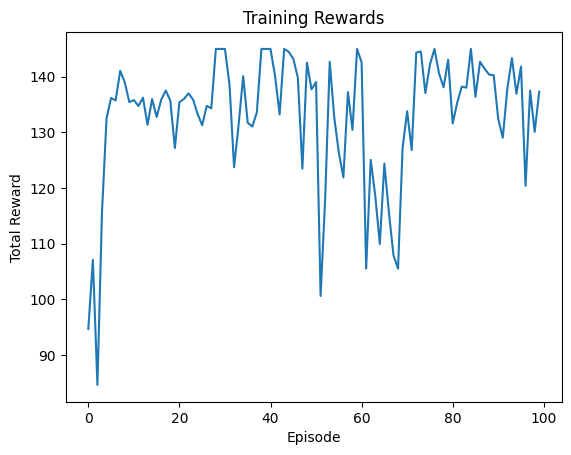

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        # neural network 2 input layers position and velocity, 1 output action left neutral right
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_size, action_size, sync_rate):
        self.state_size = state_size # state size 2, position and velocity
        self.action_size = action_size # action size 3 [left accelerate, neutralm right accelerate]
        self.memory = deque(maxlen=50000) # size of memory stored for sampling
        self.batch_size = 128
        self.gamma = 0.99 # discount factor
        self.epsilon = 1.0
        self.epsilon_min = 0.01 # minimum epsilon value
        self.epsilon_decay = 0.995 # how fast the model will transition from exploration to the policy
        self.learning_rate = 0.0005 # adjustments of weights
        self.model = QNetwork(state_size, action_size)
        self.target_model = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_model()
        self.syn_rate = sync_rate
        self.step_count = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # random action while epsilon is still greater than .01 otherwise follow the policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            action = torch.argmax(q_values, dim=1).item()
        assert 0 <= action < self.action_size, f"Invalid action: {action}"
        return action

    def replay(self):
        self.step_count += 1
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # turning values into variables that can be worked with
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Double DQN implementation
        current_q_values = self.model(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.model(next_states).max(1)[1].unsqueeze(1)
            next_q_values = self.target_model(next_states).gather(1, next_actions)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        # syncing the models
        if self.step_count % self.syn_rate == 0:
            self.target_model.load_state_dict(self.model.state_dict())
            self.step_count = 0

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, env, num_episodes):
        rewards = []
        best_rewards = -200
        for episode in range(num_episodes):
            state, _ = env.reset()  # Updated reset API
            done = False
            truncated = False
            total_reward = 0

            while not (done or truncated):
                action = self.act(state)

                # Check for gym version and adjust unpacking accordingly
                result = env.step(action)
                if len(result) == 5:  # Gym v0.26 or later
                    next_state, reward, done, truncated, info = result
                else:  # Older Gym versions (v0.25 or earlier)
                    next_state, reward, done, info = result
                    truncated = False  # Set truncated to False for older versions

                # Reward shaping to encourage exploration and reaching the goal
                if done or truncated:
                    if next_state[0] >= env.goal_position:  # Success
                        reward = 150  # Success reward
                    else:  # Failure
                        reward = -5  # Failure penalty
                else:
                    # Base rewards
                    position_reward = next_state[0] - (-0.6)  # Position reward
                    velocity_reward = abs(next_state[1])  # Velocity reward

                    # Extra reward for moving in the right direction with good velocity
                    directional_bonus = 1 if next_state[1] > 0 and next_state[0] > state[0] else 0

                    # Combine rewards with a small time penalty
                    reward = position_reward + velocity_reward + directional_bonus - 1

                    # Clamp the individual components to prevent reward spikes
                    position_reward = min(max(position_reward, -5), 50)  # Limit position reward
                    velocity_reward = min(max(velocity_reward, -5), 50)  # Limit velocity reward

                    # Combine the clamped rewards
                    reward = position_reward + velocity_reward + directional_bonus - 0.1

                    # Clamp the final reward to the maximum allowable value
                    reward = min(reward, 150)

                # Enforce maximum cumulative total_reward per episode
                if total_reward + reward > 150:
                    reward = 150 - total_reward

                self.store_transition(state, action, reward, next_state, done or truncated)
                self.replay()

                state = next_state
                total_reward += reward

            if total_reward > best_rewards:
                best_rewards = total_reward
                print(f"Best rewards so far: {best_rewards}")
                torch.save(self.model.state_dict(), f"mountaincar_dql_best.pt")

            self.update_target_model()
            rewards.append(total_reward)
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

        return rewards

if __name__ == "__main__":
    # Create the environment
    env = gym.make('MountainCar-v0')

    # Get state and action space dimensions
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create the agent
    agent = DQNAgent(state_size, action_size, sync_rate=200)  # Less frequent sync

    # Train the agent
    rewards = agent.train(env, num_episodes=100)  # More episodes

    # Plot the rewards
    plt.plot(rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()


## Analysis and Results

with original hyperparameters

        self.memory = deque(maxlen=5000)  
        self.batch_size = 64  
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.000001  
        self.learning_rate = 0.05
      
Results:

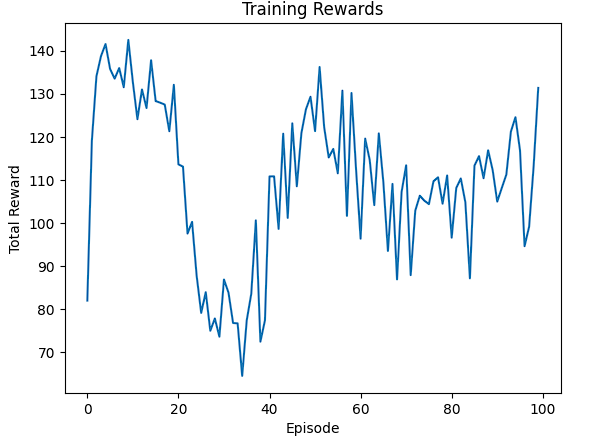

In this graph, the rewards starts off high, but struggles to find a optimal policy as we can see the reward soon drop. The pros of this graph is that it shows the growth at the 40th episode where it starts to gradually show improvements. We also ran the same hyperparameters at 200 epochs to see if the agent will improve.With these hyperparameters, we can see that the agent within this amount of episodes, never really truly finds the optimal policy, as it has difficulty increasing the rewards consistently.

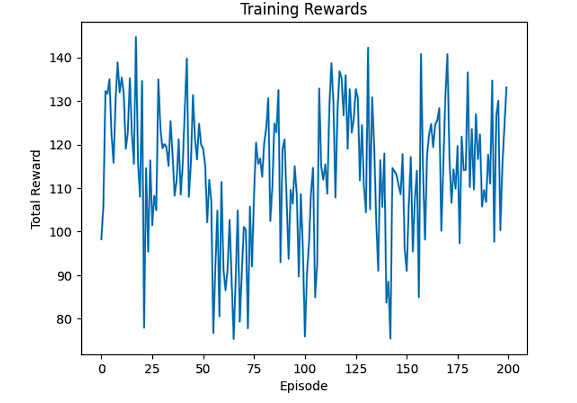

New Hyperparameters and Results

        self.memory = deque(maxlen=100000)  # Larger buffer
        self.batch_size = 128  # Larger batch size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995  # Slower decay
        self.learning_rate = 0.0005  # Lower learning rate

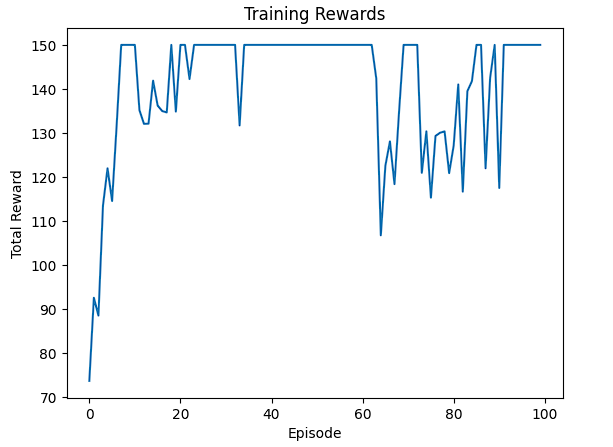

The updated hyperparameters prove to be a positive force as it allows the agent to explore the envrionment and find a more optimal policy of reaching the reward state. The agent is able to consistently find a policy to reach a reward of 150. A larger batch helps the agent learn a smoother policy and a larger buffer prevents overfitting. The learning rate was lowered to allow the agent to transition from exploring to exploitation faster. Our sync rate was also increased to introduce stability.

It is important to note, in our agent, we gave the agent multiple ways to get rewards other than the goal state. We have a reward system for the postion of the agent, a velocity reward, where it is awarded for a higher velocity,and a directional bus. This contributes to the agent reaching the maximum reward consistently, by reinforcing the positive actions. A con of this is it is simplifying the environment making it much easier for the agent to reach the goal state.
